In [ ]:
# For runpod instance
!pip install datasets > /dev/null
!pip install scikit-learn > /dev/null
!pip install umap-learn > /dev/null
!pip install matplotlib > /dev/null

In [27]:
import torch
import matplotlib.pyplot as plt
import os
import pickle

from layers import Sequential, Linear, Convolution, MaxPooling, Reshape, MSELoss, Sigmoid
from optimizer import Adam
from dataset import AffNISTDataset
from minibatch import mini_batch_training

In [ ]:
torch.set_default_device('cuda')

# Load and preprocess data


In [49]:
affnist = AffNISTDataset()
if not os.path.exists("data/affnist.npz"):
    affnist.download()
X_train, X_test, y_train, y_test = affnist.load()
train_mean = X_train.mean()
train_std = X_train.std()
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std
X_train = X_train.reshape(-1, 1, 40, 40).to('cuda' if torch.cuda.is_available() else 'cpu')
X_test = X_test.reshape(-1, 1, 40, 40).to('cuda' if torch.cuda.is_available() else 'cpu')
X_train.requires_grad = False
X_test.requires_grad = False

# Autoencoder model

In [3]:
class NNet:
    def __init__(self):
        pass
    def loss(self, y_pred, y):
        pass
    def forward(self, x):
        pass
    def backward(self):
        pass

In [4]:
class Autoencoder(NNet):
    def __init__(self, encoder, decoder, loss_obj):
        self.encoder = encoder
        self.decoder = decoder
        self.loss_obj = loss_obj
        self.Y_hat = None

    def __repr__(self):
        return f"Autoencoder(\nencoder={self.encoder}, \ndecoder={self.decoder}, \nloss={self.loss_obj})"

    def forward(self, X):
        self.Y_hat = self.decoder.forward(self.encoder.forward(X))
        return self.Y_hat

    def backward(self, Y):
        assert self.Y_hat is not None
        dY = self.loss_obj.backward(self.Y_hat, Y)
        return self.encoder.backward(self.decoder.backward(dY))

    def parameters(self):
        return self.encoder.parameters() + self.decoder.parameters()
    
    def gradients(self):
        return self.encoder.gradients() + self.decoder.gradients()
        
    def loss(self, y_hat, y):
        return self.loss_obj.forward(y_hat, y)

In [24]:
from typing import Tuple

def create_autoencoder(kernel_sizes:Tuple[int, int]=(3, 3), n_kernels:Tuple[int, int]=(4, 8)) -> Autoencoder:
    conv1_kernel_size = kernel_sizes[0]
    conv2_kernel_size = kernel_sizes[1]
    conv1_n_kernels = n_kernels[0]
    conv2_n_kernels = n_kernels[1]
    conv1_padding_keep_dims = (conv1_kernel_size - 1) // 2
    conv2_padding_keep_dims = (conv2_kernel_size - 1) // 2
    conv1 = Convolution(1, conv1_n_kernels, conv1_kernel_size, padding=conv1_padding_keep_dims)
    sigmoid1 = Sigmoid()
    pool1 = MaxPooling(2, 2)
    conv2 = Convolution(conv1_n_kernels, conv2_n_kernels, conv2_kernel_size, padding=conv2_padding_keep_dims)
    sigmoid2 = Sigmoid()
    pool2 = MaxPooling(2, 2)
    flatten = Reshape((conv2_n_kernels*10*10,))
    linear1 = Linear(conv2_n_kernels*10*10, 1*40*40//2)
    sigmoid3 = Sigmoid()
    linear2 = Linear(1*40*40//2, 1*40*40)
    unflatten = Reshape((1, 40, 40))
    mse = MSELoss()

    encoder = Sequential([conv1, sigmoid1, pool1, conv2, sigmoid2, pool2, flatten])
    decoder = Sequential([linear1, sigmoid3, linear2, unflatten])
    return Autoencoder(encoder, decoder, mse)

In [18]:
if not os.path.exists("models"):
    os.mkdir("models")

In [29]:
hyperparams = {
    "kernel_sizes": [(3, 3), (5, 5), (8, 8)],
    "n_kernels": [(1, 2), (2, 4), (16, 32)]
}
hyperparam_combinations = [(ks, nk) for ks in hyperparams["kernel_sizes"] for nk in hyperparams["n_kernels"]]
models = [create_autoencoder(ks, nk) for ks, nk in hyperparam_combinations]
models_train_losses = []
models_test_losses = []

for hyperparam_combination, model in zip(hyperparam_combinations, models):
    print(f"Training model with hyperparameters {hyperparam_combination}")
    optimizer = Adam(model.parameters(), model.gradients(), lr=0.001)
    model_train_losses, model_test_losses = mini_batch_training(
        nnet=model,
        X_train=X_train,
        y_train=X_train,
        X_test=X_test,
        y_test=X_test,
        optimizer=optimizer,
        batch_size=128,
        num_epochs=15
    )
    models_train_losses.append(model_train_losses)
    models_test_losses.append(model_test_losses)
    with open(f"models/{'_'.join(['-'.join([str(h) for h in hpr]) for hpr in hyperparam_combination])}.pkl", "wb") as f:
        pickle.dump(model, f)

Training model with hyperparameters ((3, 3), (1, 2))
Epoch 1/15 | Train Loss: 0.6100092530250549 | Test Loss: 0.6240686774253845
Epoch 2/15 | Train Loss: 0.47808021306991577 | Test Loss: 0.49162885546684265
Epoch 3/15 | Train Loss: 0.4096786081790924 | Test Loss: 0.4195254445075989
Epoch 4/15 | Train Loss: 0.371529221534729 | Test Loss: 0.36867254972457886
Epoch 5/15 | Train Loss: 0.3467392325401306 | Test Loss: 0.3499995768070221
Epoch 6/15 | Train Loss: 0.32778722047805786 | Test Loss: 0.32619884610176086
Epoch 7/15 | Train Loss: 0.31334689259529114 | Test Loss: 0.3164628744125366
Epoch 8/15 | Train Loss: 0.30357465147972107 | Test Loss: 0.30498257279396057
Epoch 9/15 | Train Loss: 0.2940531373023987 | Test Loss: 0.2921847403049469
Epoch 10/15 | Train Loss: 0.2850727438926697 | Test Loss: 0.2871241271495819
Epoch 11/15 | Train Loss: 0.2737750709056854 | Test Loss: 0.2786200940608978
Epoch 12/15 | Train Loss: 0.2645871341228485 | Test Loss: 0.26492416858673096
Epoch 13/15 | Train Loss

KeyboardInterrupt: 

In [ ]:
models_train_losses = [[m.cpu() for m in model_train_losses] for model_train_losses in models_train_losses]
models_test_losses = [[m.cpu() for m in model_test_losses] for model_test_losses in models_test_losses]

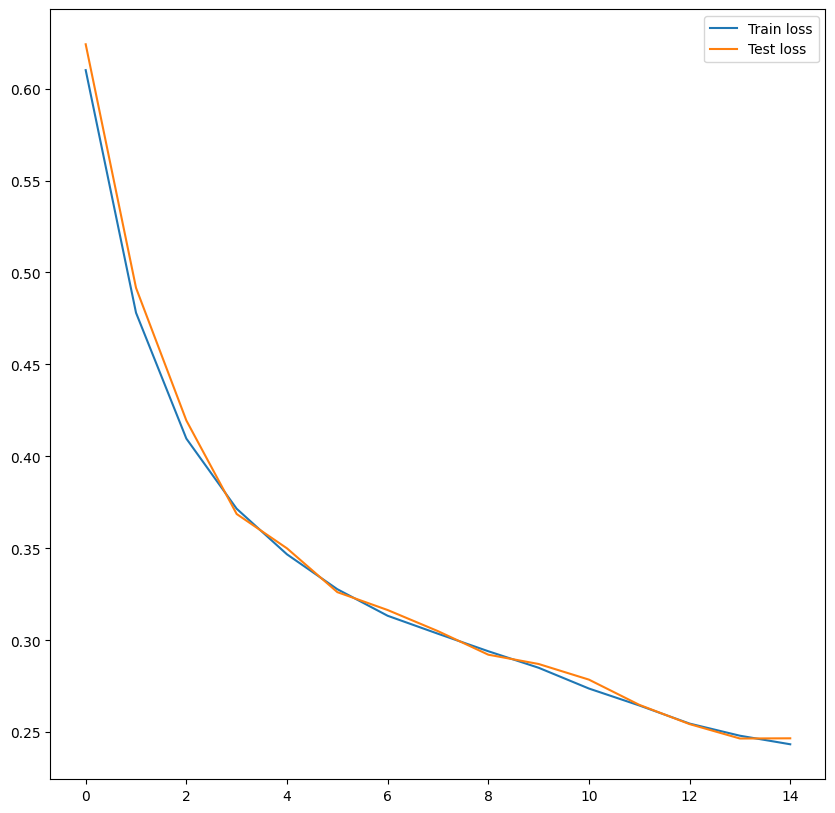

In [35]:
plt.figure(figsize=(10, 10))
plt.plot(models_train_losses[0], label="Train loss")
plt.plot(models_test_losses[0], label="Test loss")
plt.legend()

In [41]:
# Save model loss graphs for all models
for i, (model_train_losses, model_test_losses) in enumerate(zip(models_train_losses, models_test_losses)):
    plt.figure(figsize=(10, 10))
    plt.plot(model_train_losses, label="Train loss")
    plt.plot(model_test_losses, label="Test loss")
    plt.legend()
    plt.savefig(f"models/loss_{'_'.join(['-'.join([str(h) for h in hpr]) for hpr in hyperparam_combinations[i]])}.png")
    plt.close()

In [45]:
# Save images of digits and reconstructions for first 10 images in test set (all 10 digits in same graph)

def save_images_reconstructions(model, X_test, y_test, save_path):
    # Select first 10 images from test set
    X_subset = X_test[:10]
    y_subset = y_test[:10]

    # Generate reconstructions
    reconstructions = model.forward(X_subset)

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

    # Plot original images
    for i in range(10):
        axes[0, i].imshow(X_subset[i].reshape(40, 40).cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Label: {y_subset[i]}")

    # Plot reconstructed images
    for i in range(10):
        axes[1, i].imshow(reconstructions[i].reshape(40, 40).cpu(), cmap='gray')
        axes[1, i].axis('off')

    # Save the figure
    plt.savefig(save_path)
    plt.close()

for i, model in enumerate(models):
    save_images_reconstructions(model, X_test, y_test, f"models/reconstructions_{'_'.join(['-'.join([str(h) for h in hpr]) for hpr in hyperparam_combinations[i]])}.png")


In [48]:
from umap import UMAP

# for each model, save a 2d umap plot of the latent space representation of X_test
for i, model in enumerate(models):
    encoder = model.encoder
    latent_space = encoder.forward(X_test)
    umap = UMAP()
    umap.fit(latent_space.detach().numpy(), y_test)
    plt.figure(figsize=(10, 10))
    plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=y_test, cmap='Spectral', s=5)
    plt.savefig(f"models/umap_{'_'.join(['-'.join([str(h) for h in hpr]) for hpr in hyperparam_combinations[i]])}.png")
    plt.close()

In [50]:
# Save one umap of raw affnist data
umap = UMAP()
umap.fit(X_test.reshape(-1, 40*40).detach().numpy(), y_test)
plt.figure(figsize=(10, 10))
plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=y_test, cmap='Spectral', s=5)
plt.savefig(f"models/umap_raw.png")
plt.close()

In [51]:
# Best model :

for model, hyperparam_combination in zip(models, hyperparam_combinations):
    y_hat = model.forward(X_test)
    loss = model.loss(y_hat, X_test)
    print(f"Model with hyperparameters {hyperparam_combination} has loss {loss}")

Model with hyperparameters ((3, 3), (1, 2)) has loss 0.2426500767469406
